## VAE

### AutoEncoder

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='../chap13/data', train=True, transform=transform, download=True)

test_dataset = datasets.MNIST(root='../chap13/data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=False)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [3]:
class Encoder(nn.Module):    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
    
class Decoder(nn.Module):    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [4]:
encoder = Encoder(encoded_space_dim=4, fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=4, fc2_input_dim=128)
encoder.to(device)
decoder.to(device)

params_to_optimize = [{'params': encoder.parameters()},
                     {'params': decoder.parameters()}
                     ]
optim = torch.optim.Adam(params_to_optimize, lr=0.001, weight_decay=1e-05)
loss_fn = torch.nn.MSELoss()

In [5]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer, noise_factor=0.3):
    encoder.train()
    decoder.train()
    train_loss = []
    for image_batch, _ in dataloader:
        image_noisy = add_noise(image_batch, noise_factor)
        image_noisy = image_noisy.to(device)
        encoded_data = encoder(image_noisy)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data,image_noisy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

In [6]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn, noise_factor=0.3):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            encoded_data = encoder(image_batch)
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [7]:
def add_noise(inputs, noise_factor=0.3):
    noisy = inputs + torch.randn_like(inputs)*noise_factor
    noisy = torch.clip(noisy,0.,1.)
    return noisy

In [8]:
# from matplotlib import font_manager
# font_fname= 'C:/Windows?Fonts/malgun.ttf'
# font_family = font_manager.FontProperties(fname=font_fname).get_name()
# plt.rcParams['font.family']=font_family

In [9]:
def plot_ae_outputs(encoder,decoder,n=5,noise_factor=0.3):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
        ax = plt.subplot(3,n,i+1)
        img = test_dataset[i][0].unsqueeze(0)
        image_noisy = add_noise(img,noise_factor)     
        image_noisy = image_noisy.to(device)

        encoder.eval()
        decoder.eval()

        with torch.no_grad():
            rec_img  = decoder(encoder(image_noisy))

        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('원래 이미지')
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('노이즈가 적용되어 손상된 이미지')

        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('재구성된 이미지')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show()

EPOCH 1/30

 EPOCH 1/30 	 train loss 0.083 	 val loss 0.056


C:\Users\Seungyun\anaconda3\envs\torch_book\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Seungyun\anaconda3\envs\torch_book\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Seungyun\anaconda3\envs\torch_book\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Seungyun\anaconda3\envs\torch_book\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Seungyun\anaconda3\envs\torch_book\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) mi

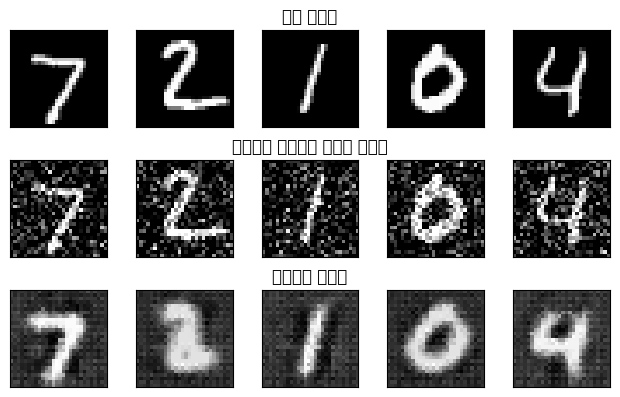

EPOCH 2/30

 EPOCH 2/30 	 train loss 0.059 	 val loss 0.051


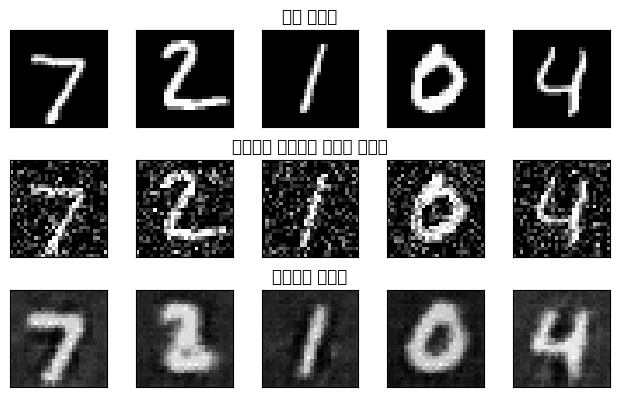

EPOCH 3/30

 EPOCH 3/30 	 train loss 0.056 	 val loss 0.047


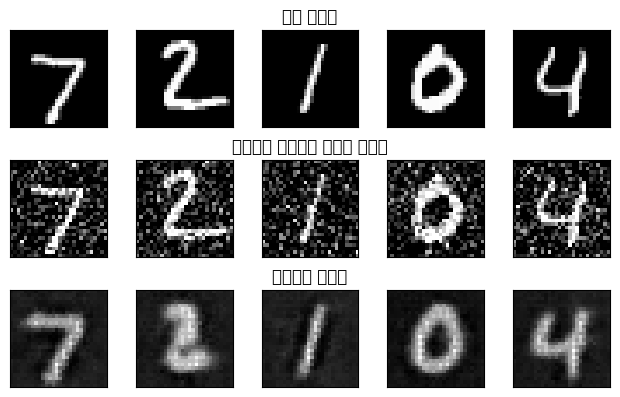

EPOCH 4/30

 EPOCH 4/30 	 train loss 0.054 	 val loss 0.043


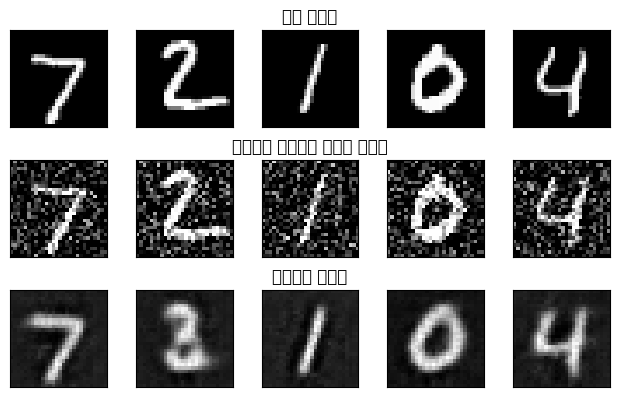

EPOCH 5/30

 EPOCH 5/30 	 train loss 0.052 	 val loss 0.042


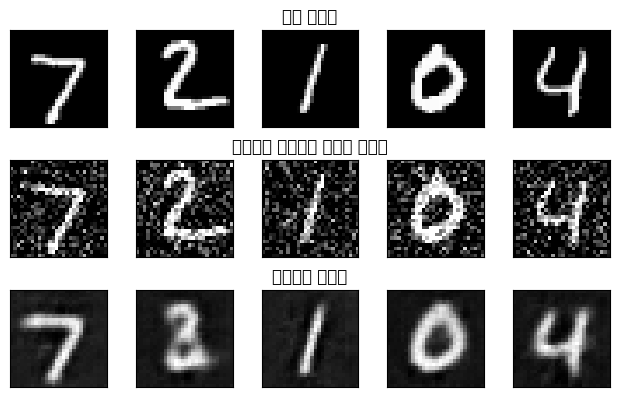

EPOCH 6/30

 EPOCH 6/30 	 train loss 0.052 	 val loss 0.041


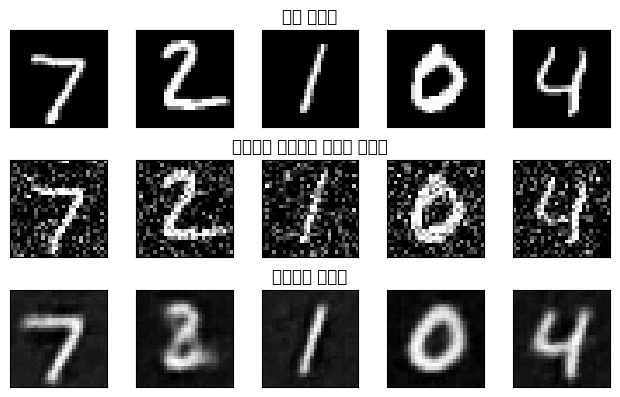

EPOCH 7/30

 EPOCH 7/30 	 train loss 0.051 	 val loss 0.041


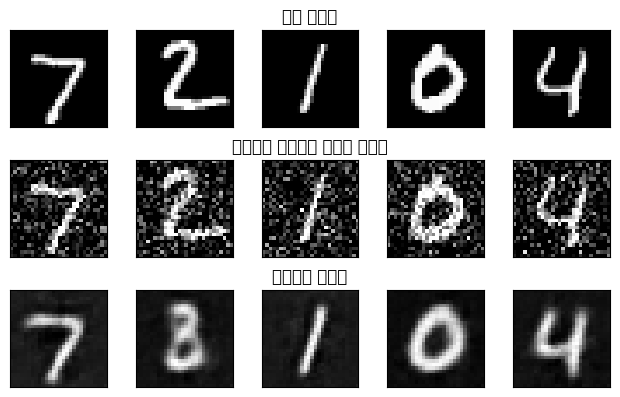

EPOCH 8/30

 EPOCH 8/30 	 train loss 0.051 	 val loss 0.040


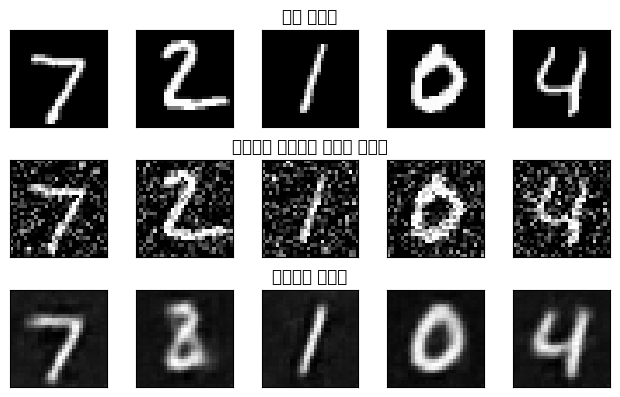

EPOCH 9/30

 EPOCH 9/30 	 train loss 0.051 	 val loss 0.040


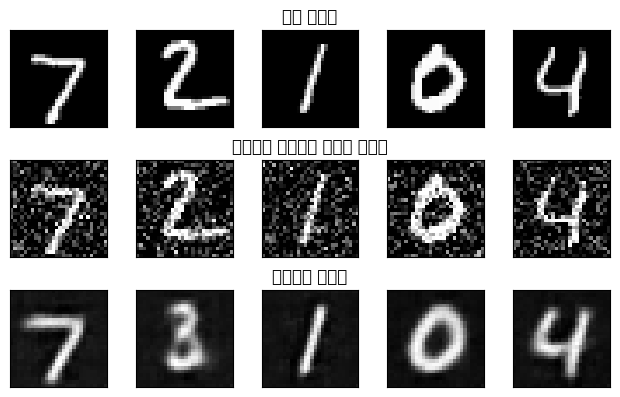

EPOCH 10/30

 EPOCH 10/30 	 train loss 0.051 	 val loss 0.040


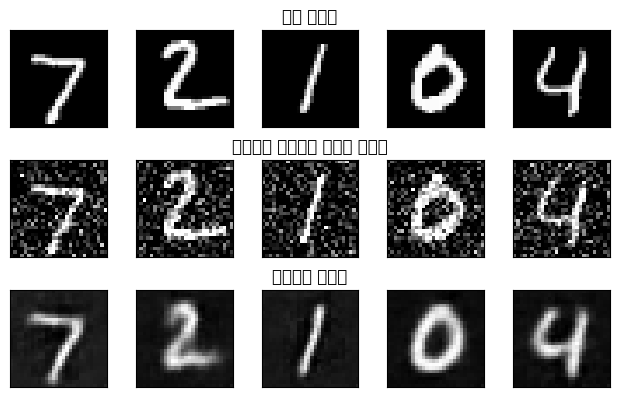

EPOCH 11/30

 EPOCH 11/30 	 train loss 0.051 	 val loss 0.039


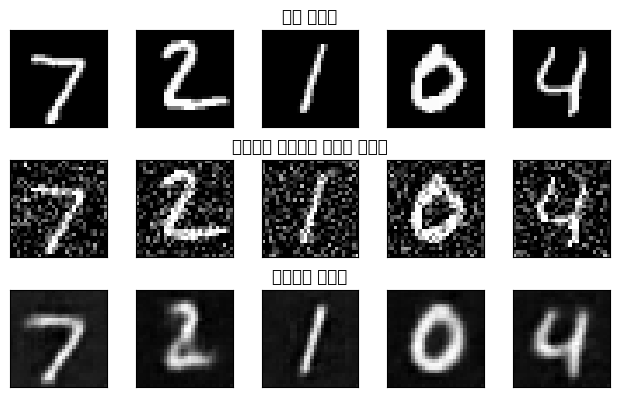

EPOCH 12/30

 EPOCH 12/30 	 train loss 0.050 	 val loss 0.039


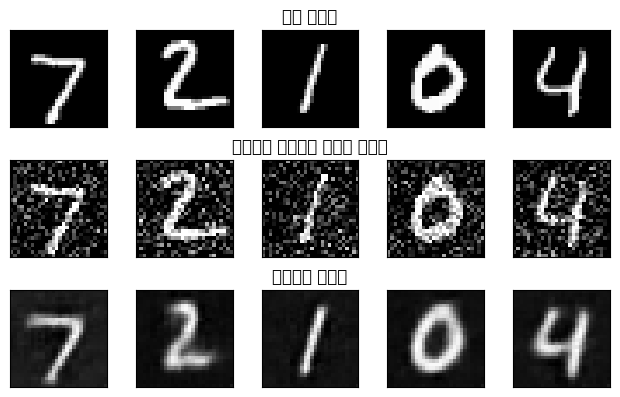

EPOCH 13/30

 EPOCH 13/30 	 train loss 0.050 	 val loss 0.039


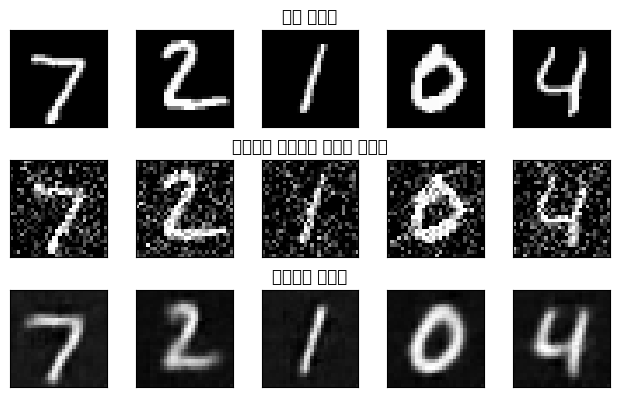

EPOCH 14/30

 EPOCH 14/30 	 train loss 0.050 	 val loss 0.039


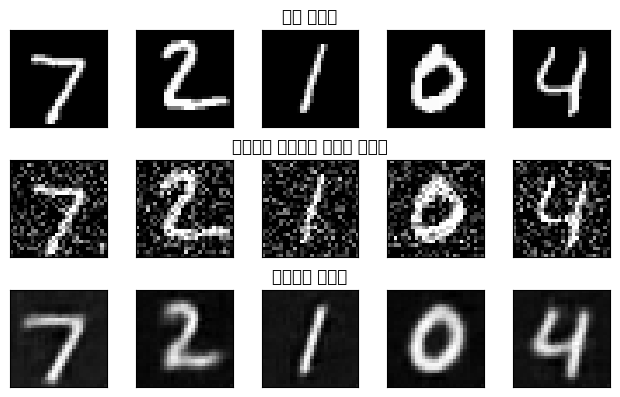

EPOCH 15/30

 EPOCH 15/30 	 train loss 0.050 	 val loss 0.039


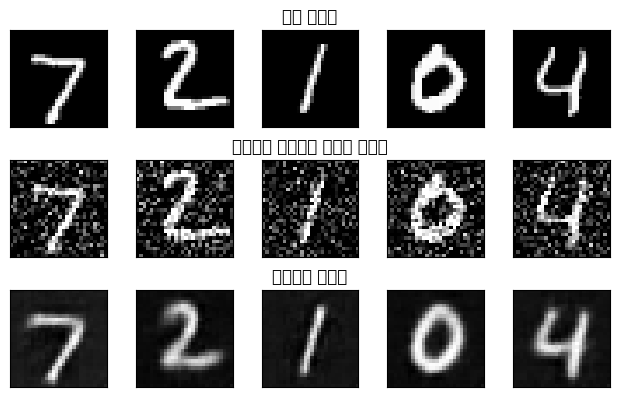

EPOCH 16/30

 EPOCH 16/30 	 train loss 0.050 	 val loss 0.039


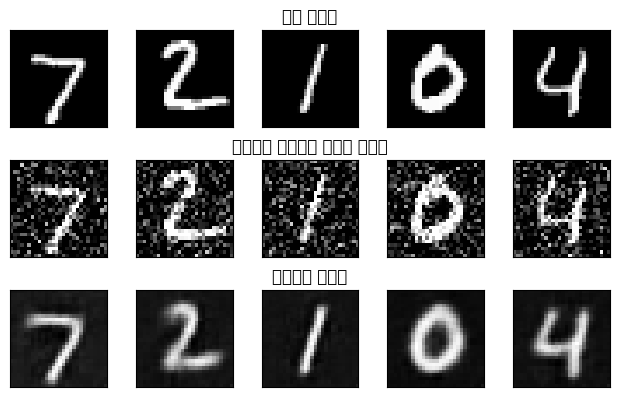

EPOCH 17/30

 EPOCH 17/30 	 train loss 0.050 	 val loss 0.039


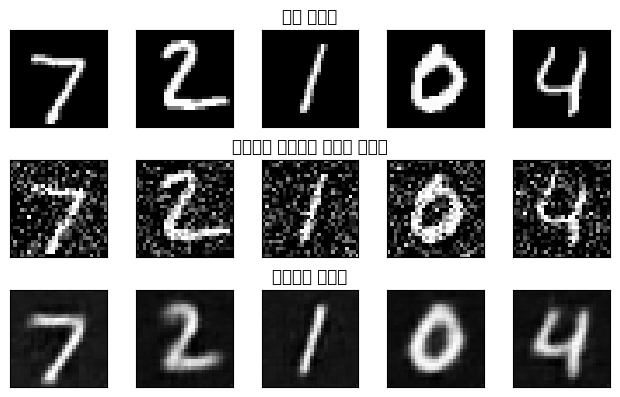

EPOCH 18/30

 EPOCH 18/30 	 train loss 0.050 	 val loss 0.038


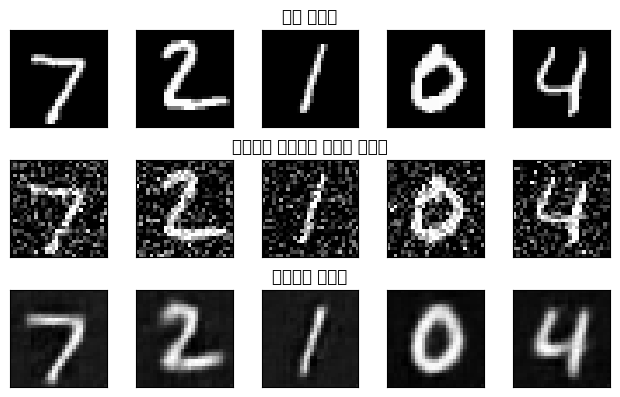

EPOCH 19/30

 EPOCH 19/30 	 train loss 0.050 	 val loss 0.038


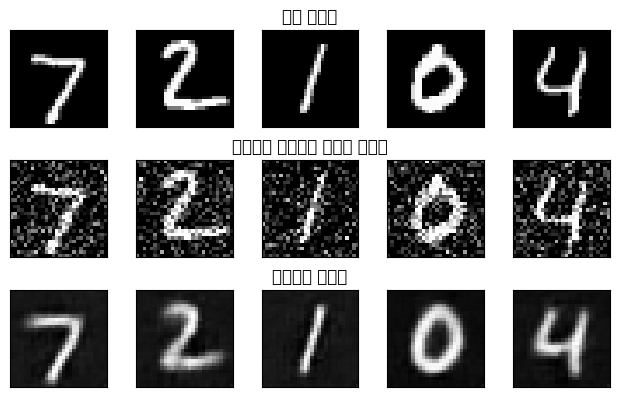

EPOCH 20/30

 EPOCH 20/30 	 train loss 0.050 	 val loss 0.039


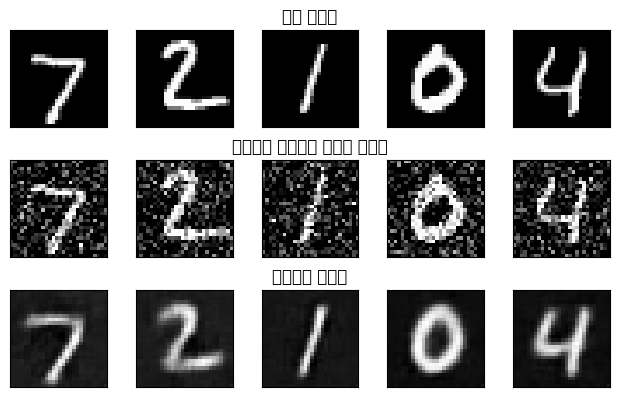

EPOCH 21/30

 EPOCH 21/30 	 train loss 0.050 	 val loss 0.038


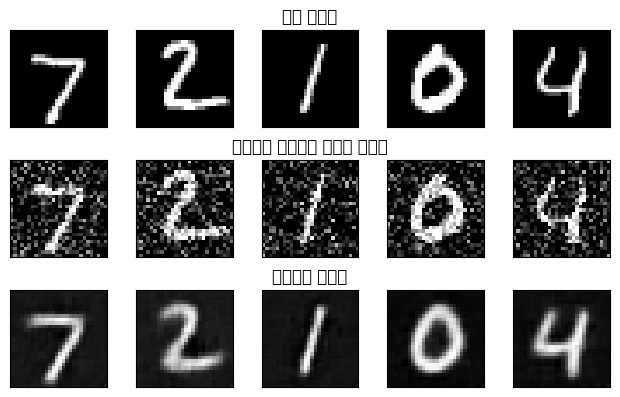

EPOCH 22/30

 EPOCH 22/30 	 train loss 0.050 	 val loss 0.038


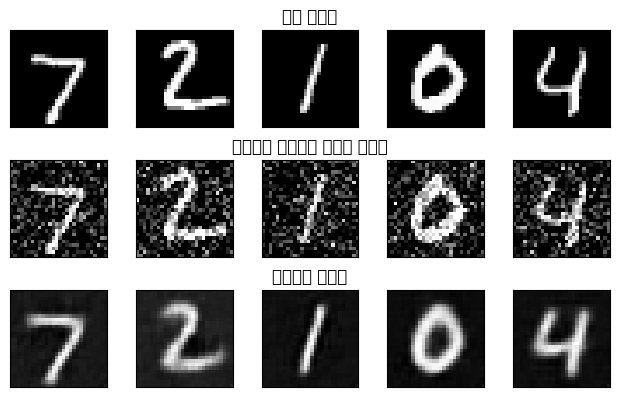

EPOCH 23/30

 EPOCH 23/30 	 train loss 0.050 	 val loss 0.038


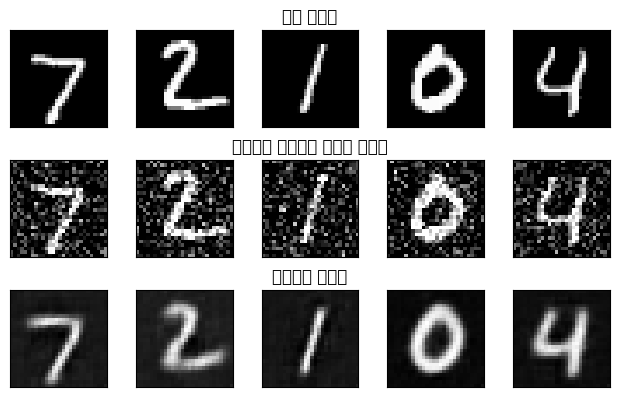

EPOCH 24/30

 EPOCH 24/30 	 train loss 0.050 	 val loss 0.038


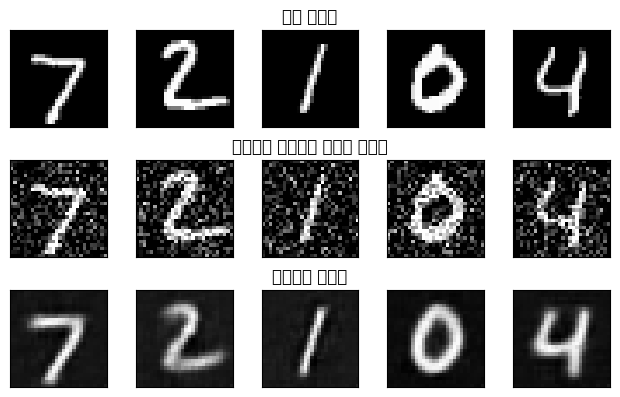

EPOCH 25/30

 EPOCH 25/30 	 train loss 0.050 	 val loss 0.038


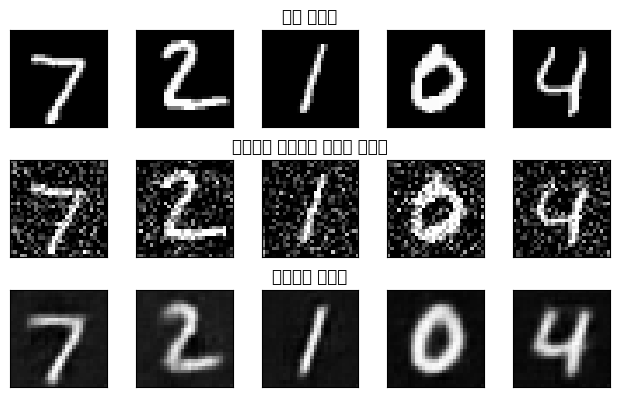

EPOCH 26/30

 EPOCH 26/30 	 train loss 0.050 	 val loss 0.038


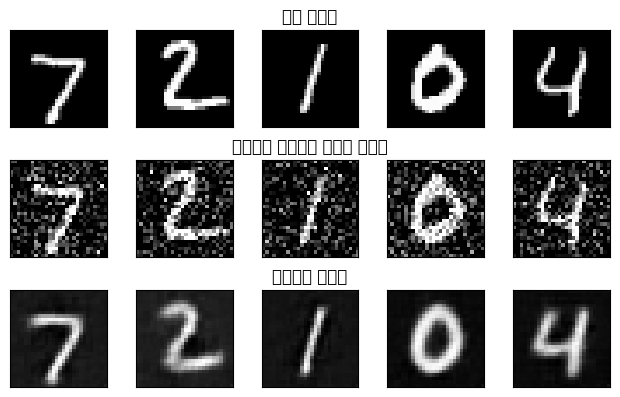

EPOCH 27/30

 EPOCH 27/30 	 train loss 0.050 	 val loss 0.038


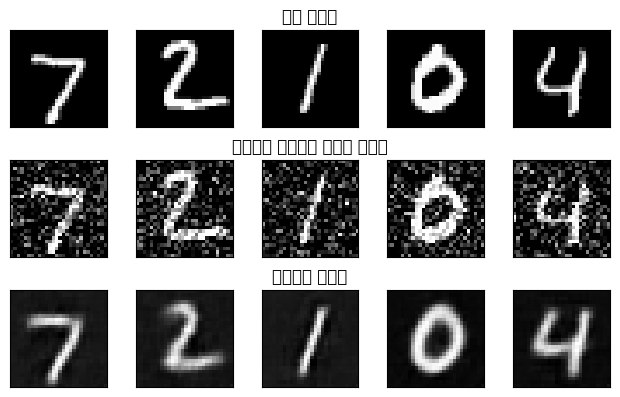

EPOCH 28/30

 EPOCH 28/30 	 train loss 0.050 	 val loss 0.038


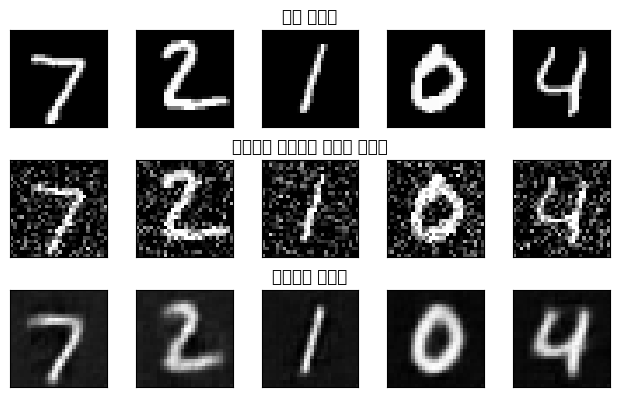

EPOCH 29/30

 EPOCH 29/30 	 train loss 0.049 	 val loss 0.038


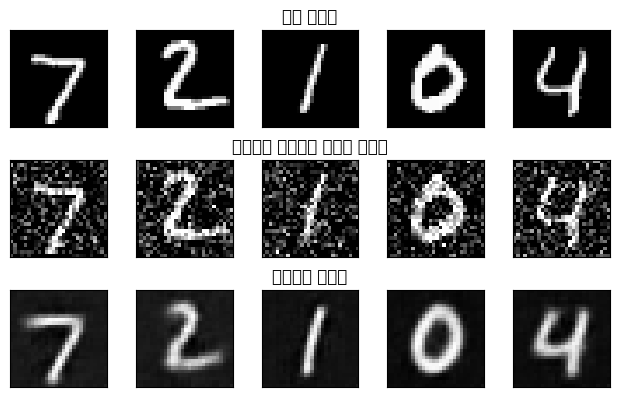

EPOCH 30/30

 EPOCH 30/30 	 train loss 0.049 	 val loss 0.038


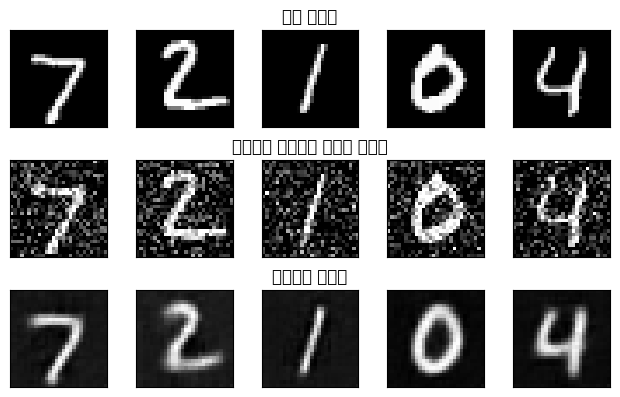

In [10]:
import numpy as np

num_epochs = 30
history_da = {'train_loss':[],'val_loss':[]}
loss_fn = torch.nn.MSELoss()

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch+1, num_epochs))
    train_loss = train_epoch(
        encoder=encoder,
        decoder=decoder,
        device=device,
        dataloader=train_loader,
        loss_fn=loss_fn,
        optimizer=optim, noise_factor=0.3)
    val_loss = test_epoch(
        encoder=encoder,
        decoder=decoder,
        device=device,
        dataloader=test_loader,
        loss_fn=loss_fn, noise_factor=0.3)
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch+1,num_epochs, train_loss, val_loss))
    plot_ae_outputs(encoder, decoder, noise_factor=0.3)

### VAE

In [11]:
import datetime
import os
from tensorboardX import SummaryWriter

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(
    root="../chap13/data", train=True, transform=transform, download=True)

test_dataset = datasets.MNIST(
    root="../chap13/data", train=False, transform=transform, download=True)

train_loader = DataLoader(
    train_dataset, batch_size=100, shuffle=True, num_workers=4, pin_memory=False)

test_loader = DataLoader(
    test_dataset, batch_size=100, shuffle=False, num_workers=4)

In [13]:
class Encoder(nn.Module):
    def __init__(self,input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.input1 = nn.Linear(input_dim, hidden_dim)
        self.input2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear(hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True
        
    def forward(self,x):
        h_ = self.LeakyReLU(self.input1(x))
        h_ = self.LeakyReLU(self.input2(h_))
        mean = self.mean(h_)
        log_var = self.var(h_)
        return mean, log_var

In [14]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self,x):
        h = self.LeakyReLU(self.hidden1(x))
        h = self.LeakyReLU(self.hidden2(h))
        x_hat = torch.sigmoid(self.output(h))
        return x_hat

In [15]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var*epsilon
        return z
    
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5*log_var))
        x_hat = self.Decoder(z)
        return x_hat, mean, log_var

In [16]:
x_dim = 784
hidden_dim = 400
latent_dim = 200
epochs = 30
batch_size = 100

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)

model=Model(Encoder=encoder, Decoder=decoder).to(device)

In [17]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5*torch.sum(1+log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss, KLD

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [18]:
saved_loc = 'scalar/'
writer = SummaryWriter(saved_loc)

model.train()
def train(epoch, model, train_loader, optimizer):
    train_loss = 0
    for batch_idx, (x,_) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)
        
        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)
        BCE, KLD = loss_function(x, x_hat, mean, log_var)
        loss = BCE + KLD
        writer.add_scalar("Train/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        writer.add_scalar("Train/KL-Divergence", KLD.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        writer.add_scalar("Train/Total Loss" , loss.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(epoch, batch_idx*len(x), len(train_loader.dataset), 
                                                                            100.*batch_idx / len(train_loader),
                                                                           loss.item() / len(x)))
            
    print("=======> Epoch: {} Average loss: {:.4f}".format(epoch, train_loss / len(train_loader.dataset)))

In [19]:
def test(epoch, model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(test_loader):
            x = x.view(batch_size, x_dim)
            x = x.to(device)        
            x_hat, mean, log_var = model(x)
            BCE, KLD = loss_function(x, x_hat, mean, log_var)
            loss = BCE + KLD
        
            writer.add_scalar("Test/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            writer.add_scalar("Test/KL-Divergence", KLD.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            writer.add_scalar("Test/Total Loss" , loss.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            test_loss += loss.item()

            if batch_idx == 0:
                n = min(x.size(0), 8)
                comparison = torch.cat([x[:n], x_hat.view(batch_size, x_dim)[:n]])
                grid = torchvision.utils.make_grid(comparison.cpu()) 
                writer.add_image("Test image - Above: Real data, below: reconstruction data", grid, epoch)

In [20]:
from tqdm.auto import tqdm
for epoch in tqdm(range(0, epochs)):
    train(epoch, model, train_loader, optimizer)
    test(epoch, model, test_loader)
    print("\n")
writer.close()

  0%|          | 0/30 [00:00<?, ?it/s]

Train Epoch: 0 [0/60000 (0%)]	 Loss: 545.177969
Train Epoch: 0 [10000/60000 (17%)]	 Loss: 193.992070
Train Epoch: 0 [20000/60000 (33%)]	 Loss: 181.013223
Train Epoch: 0 [30000/60000 (50%)]	 Loss: 169.329492
Train Epoch: 0 [40000/60000 (67%)]	 Loss: 157.864844
Train Epoch: 0 [50000/60000 (83%)]	 Loss: 148.688437
=======> Epoch: 0 Average loss: 175.4855


Train Epoch: 1 [0/60000 (0%)]	 Loss: 134.907480
Train Epoch: 1 [10000/60000 (17%)]	 Loss: 137.701270
Train Epoch: 1 [20000/60000 (33%)]	 Loss: 133.029414
Train Epoch: 1 [30000/60000 (50%)]	 Loss: 131.256465
Train Epoch: 1 [40000/60000 (67%)]	 Loss: 119.501367
Train Epoch: 1 [50000/60000 (83%)]	 Loss: 127.441660
=======> Epoch: 1 Average loss: 130.8666


Train Epoch: 2 [0/60000 (0%)]	 Loss: 118.945371
Train Epoch: 2 [10000/60000 (17%)]	 Loss: 121.376338
Train Epoch: 2 [20000/60000 (33%)]	 Loss: 119.234277
Train Epoch: 2 [30000/60000 (50%)]	 Loss: 115.494629
Train Epoch: 2 [40000/60000 (67%)]	 Loss: 116.499121
Train Epoch: 2 [50000/60000 

=======> Epoch: 22 Average loss: 100.9321


Train Epoch: 23 [0/60000 (0%)]	 Loss: 101.001865
Train Epoch: 23 [10000/60000 (17%)]	 Loss: 99.141738
Train Epoch: 23 [20000/60000 (33%)]	 Loss: 102.082500
Train Epoch: 23 [30000/60000 (50%)]	 Loss: 99.296709
Train Epoch: 23 [40000/60000 (67%)]	 Loss: 98.165840
Train Epoch: 23 [50000/60000 (83%)]	 Loss: 94.627920
=======> Epoch: 23 Average loss: 100.8344


Train Epoch: 24 [0/60000 (0%)]	 Loss: 101.219277
Train Epoch: 24 [10000/60000 (17%)]	 Loss: 99.337607
Train Epoch: 24 [20000/60000 (33%)]	 Loss: 102.589922
Train Epoch: 24 [30000/60000 (50%)]	 Loss: 103.762266
Train Epoch: 24 [40000/60000 (67%)]	 Loss: 103.069805
Train Epoch: 24 [50000/60000 (83%)]	 Loss: 101.504277
=======> Epoch: 24 Average loss: 100.6196


Train Epoch: 25 [0/60000 (0%)]	 Loss: 100.840195
Train Epoch: 25 [10000/60000 (17%)]	 Loss: 99.561504
Train Epoch: 25 [20000/60000 (33%)]	 Loss: 100.251602
Train Epoch: 25 [30000/60000 (50%)]	 Loss: 100.012754
Train Epoch: 25 [40000/60

In [21]:
%load_ext tensorboard
%tensorboard --logdir scalar --port=6013

## GAN

In [22]:
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib
import matplotlib.pyplot as plt

from torchvision.utils import make_grid, save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
matplotlib.style.use('ggplot')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
batch_size = 512
epochs = 200
sample_size = 64 
nz = 128 
k = 1 

In [24]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

train_dataset = datasets.MNIST(
    root="../chap13/data", train=True, transform=transform, download=True)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [25]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024,784),
            nn.Tanh()
        )
        
    def forward(self,x):
        return self.main(x).view(-1,1,28,28)

In [26]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256,1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.view(-1,784)
        return self.main(x)

In [27]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print(generator)
print(discriminator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [28]:
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

losses_g = [] 
losses_d = [] 
images = [] 

In [29]:
def save_generator_image(image, path):
    save_image(image, path)

In [30]:
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = torch.ones(b_size, 1).to(device)
    fake_label = torch.zeros(b_size, 1).to(device)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [31]:
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)    
    real_label = torch.ones(b_size, 1).to(device)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [32]:
generator.train()
discriminator.train()

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for idx, data in tqdm(enumerate(train_loader), total=int(len(train_dataset)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        for step in range(k):                                
            data_fake = generator(torch.randn(b_size, nz).to(device)).detach()
            data_real = image
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(torch.randn(b_size, nz).to(device))
        loss_g += train_generator(optim_g, data_fake)
    generated_img = generator(torch.randn(b_size, nz).to(device)).cpu().detach()
    generated_img = make_grid(generated_img)
    save_generator_image(generated_img, f"../chap13/img/gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / idx 
    epoch_loss_d = loss_d / idx 
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

118it [00:13,  8.65it/s]                                                                                               


Epoch 0 of 200
Generator loss: 1.33562934, Discriminator loss: 0.96028918


118it [00:13,  8.96it/s]                                                                                               


Epoch 1 of 200
Generator loss: 2.59571910, Discriminator loss: 1.05203831


118it [00:12,  9.26it/s]                                                                                               


Epoch 2 of 200
Generator loss: 7.45486116, Discriminator loss: 0.07580823


118it [00:12,  9.37it/s]                                                                                               


Epoch 3 of 200
Generator loss: 6.95438623, Discriminator loss: 0.38973311


118it [00:10, 10.94it/s]                                                                                               


Epoch 4 of 200
Generator loss: 3.98258948, Discriminator loss: 0.76911688


118it [00:10, 11.17it/s]                                                                                               


Epoch 5 of 200
Generator loss: 4.27287292, Discriminator loss: 1.11238050


118it [00:10, 11.04it/s]                                                                                               


Epoch 6 of 200
Generator loss: 7.31135559, Discriminator loss: 0.37605402


118it [00:10, 11.12it/s]                                                                                               


Epoch 7 of 200
Generator loss: 2.89688230, Discriminator loss: 1.18169439


118it [00:10, 11.09it/s]                                                                                               


Epoch 8 of 200
Generator loss: 1.31521714, Discriminator loss: 0.93983692


118it [00:10, 11.07it/s]                                                                                               


Epoch 9 of 200
Generator loss: 1.59145248, Discriminator loss: 1.03541446


118it [00:10, 11.25it/s]                                                                                               


Epoch 10 of 200
Generator loss: 2.69057226, Discriminator loss: 0.72992206


118it [00:10, 11.10it/s]                                                                                               


Epoch 11 of 200
Generator loss: 2.06829596, Discriminator loss: 0.96444625


118it [00:10, 10.95it/s]                                                                                               


Epoch 12 of 200
Generator loss: 2.07953024, Discriminator loss: 1.18809855


118it [00:10, 11.14it/s]                                                                                               


Epoch 13 of 200
Generator loss: 1.56597042, Discriminator loss: 0.96735805


118it [00:10, 11.04it/s]                                                                                               


Epoch 14 of 200
Generator loss: 2.26049995, Discriminator loss: 0.99249119


118it [00:10, 11.11it/s]                                                                                               


Epoch 15 of 200
Generator loss: 1.79555535, Discriminator loss: 0.98006392


118it [00:10, 11.20it/s]                                                                                               


Epoch 16 of 200
Generator loss: 2.74870396, Discriminator loss: 0.75918674


118it [00:10, 11.18it/s]                                                                                               


Epoch 17 of 200
Generator loss: 2.88797617, Discriminator loss: 0.88427365


118it [00:10, 11.12it/s]                                                                                               


Epoch 18 of 200
Generator loss: 2.84250951, Discriminator loss: 0.63101190


118it [00:10, 11.06it/s]                                                                                               


Epoch 19 of 200
Generator loss: 2.71538544, Discriminator loss: 0.84000832


118it [00:10, 11.08it/s]                                                                                               


Epoch 20 of 200
Generator loss: 2.51288104, Discriminator loss: 0.71076745


118it [00:10, 11.18it/s]                                                                                               


Epoch 21 of 200
Generator loss: 2.54869604, Discriminator loss: 0.59863818


118it [00:10, 11.19it/s]                                                                                               


Epoch 22 of 200
Generator loss: 2.83667421, Discriminator loss: 0.44056213


118it [00:10, 11.07it/s]                                                                                               


Epoch 23 of 200
Generator loss: 3.29046226, Discriminator loss: 0.42092445


118it [00:10, 11.08it/s]                                                                                               


Epoch 24 of 200
Generator loss: 3.77618432, Discriminator loss: 0.43688416


118it [00:10, 10.79it/s]                                                                                               


Epoch 25 of 200
Generator loss: 3.86502957, Discriminator loss: 0.45786411


118it [00:10, 11.15it/s]                                                                                               


Epoch 26 of 200
Generator loss: 4.07474279, Discriminator loss: 0.55040759


118it [00:10, 11.06it/s]                                                                                               


Epoch 27 of 200
Generator loss: 2.56512856, Discriminator loss: 0.49263182


118it [00:10, 11.07it/s]                                                                                               


Epoch 28 of 200
Generator loss: 3.39375901, Discriminator loss: 0.37651744


118it [00:10, 11.07it/s]                                                                                               


Epoch 29 of 200
Generator loss: 3.48249269, Discriminator loss: 0.46507308


118it [00:10, 11.22it/s]                                                                                               


Epoch 30 of 200
Generator loss: 3.03881121, Discriminator loss: 0.42589158


118it [00:10, 11.15it/s]                                                                                               


Epoch 31 of 200
Generator loss: 3.21544576, Discriminator loss: 0.35573086


118it [00:10, 11.04it/s]                                                                                               


Epoch 32 of 200
Generator loss: 3.54656291, Discriminator loss: 0.41141012


118it [00:10, 11.17it/s]                                                                                               


Epoch 33 of 200
Generator loss: 2.63440657, Discriminator loss: 0.63322771


118it [00:10, 11.09it/s]                                                                                               


Epoch 34 of 200
Generator loss: 3.13819623, Discriminator loss: 0.43072304


118it [00:10, 11.04it/s]                                                                                               


Epoch 35 of 200
Generator loss: 2.65587401, Discriminator loss: 0.70185494


118it [00:10, 11.02it/s]                                                                                               


Epoch 36 of 200
Generator loss: 2.98369265, Discriminator loss: 0.49460876


118it [00:10, 11.08it/s]                                                                                               


Epoch 37 of 200
Generator loss: 3.12019825, Discriminator loss: 0.43518803


118it [00:10, 11.17it/s]                                                                                               


Epoch 38 of 200
Generator loss: 2.85522151, Discriminator loss: 0.57920766


118it [00:10, 11.02it/s]                                                                                               


Epoch 39 of 200
Generator loss: 3.09662795, Discriminator loss: 0.55009311


118it [00:10, 11.06it/s]                                                                                               


Epoch 40 of 200
Generator loss: 3.00392580, Discriminator loss: 0.46800593


118it [00:10, 11.08it/s]                                                                                               


Epoch 41 of 200
Generator loss: 3.27616143, Discriminator loss: 0.39039770


118it [00:10, 10.93it/s]                                                                                               


Epoch 42 of 200
Generator loss: 3.06244326, Discriminator loss: 0.46317065


118it [00:10, 11.23it/s]                                                                                               


Epoch 43 of 200
Generator loss: 2.75545192, Discriminator loss: 0.60466486


118it [00:10, 11.17it/s]                                                                                               


Epoch 44 of 200
Generator loss: 3.03364515, Discriminator loss: 0.51123130


118it [00:10, 11.14it/s]                                                                                               


Epoch 45 of 200
Generator loss: 3.20306897, Discriminator loss: 0.43826789


118it [00:10, 11.06it/s]                                                                                               


Epoch 46 of 200
Generator loss: 3.32998586, Discriminator loss: 0.43127456


118it [00:10, 10.99it/s]                                                                                               


Epoch 47 of 200
Generator loss: 2.69680524, Discriminator loss: 0.57658803


118it [00:10, 11.07it/s]                                                                                               


Epoch 48 of 200
Generator loss: 2.42399597, Discriminator loss: 0.67452669


118it [00:10, 11.22it/s]                                                                                               


Epoch 49 of 200
Generator loss: 2.77634287, Discriminator loss: 0.56201833


118it [00:10, 11.11it/s]                                                                                               


Epoch 50 of 200
Generator loss: 2.74946880, Discriminator loss: 0.54734594


118it [00:10, 11.17it/s]                                                                                               


Epoch 51 of 200
Generator loss: 2.63713717, Discriminator loss: 0.56942457


118it [00:10, 11.15it/s]                                                                                               


Epoch 52 of 200
Generator loss: 2.71465039, Discriminator loss: 0.48409227


118it [00:10, 11.13it/s]                                                                                               


Epoch 53 of 200
Generator loss: 2.90579891, Discriminator loss: 0.52341843


118it [00:10, 11.09it/s]                                                                                               


Epoch 54 of 200
Generator loss: 3.13493848, Discriminator loss: 0.52734631


118it [00:10, 11.11it/s]                                                                                               


Epoch 55 of 200
Generator loss: 2.73707008, Discriminator loss: 0.54237288


118it [00:10, 11.07it/s]                                                                                               


Epoch 56 of 200
Generator loss: 2.59700084, Discriminator loss: 0.66733885


118it [00:10, 11.07it/s]                                                                                               


Epoch 57 of 200
Generator loss: 2.61807466, Discriminator loss: 0.59049743


118it [00:10, 11.04it/s]                                                                                               


Epoch 58 of 200
Generator loss: 2.64844632, Discriminator loss: 0.59023601


118it [00:10, 11.12it/s]                                                                                               


Epoch 59 of 200
Generator loss: 2.79700994, Discriminator loss: 0.53904015


118it [00:10, 10.92it/s]                                                                                               


Epoch 60 of 200
Generator loss: 2.64650869, Discriminator loss: 0.60776925


118it [00:10, 11.23it/s]                                                                                               


Epoch 61 of 200
Generator loss: 2.59742808, Discriminator loss: 0.58332354


118it [00:10, 11.18it/s]                                                                                               


Epoch 62 of 200
Generator loss: 2.64783525, Discriminator loss: 0.60572720


118it [00:10, 11.11it/s]                                                                                               


Epoch 63 of 200
Generator loss: 2.40849829, Discriminator loss: 0.62446254


118it [00:10, 11.12it/s]                                                                                               


Epoch 64 of 200
Generator loss: 2.61317277, Discriminator loss: 0.58055848


118it [00:10, 11.17it/s]                                                                                               


Epoch 65 of 200
Generator loss: 2.53493953, Discriminator loss: 0.62107551


118it [00:10, 11.04it/s]                                                                                               


Epoch 66 of 200
Generator loss: 2.58035159, Discriminator loss: 0.60299397


118it [00:10, 11.16it/s]                                                                                               


Epoch 67 of 200
Generator loss: 2.50645852, Discriminator loss: 0.67821449


118it [00:10, 11.04it/s]                                                                                               


Epoch 68 of 200
Generator loss: 2.35129809, Discriminator loss: 0.69068611


118it [00:10, 11.02it/s]                                                                                               


Epoch 69 of 200
Generator loss: 2.28743887, Discriminator loss: 0.69601202


118it [00:10, 10.95it/s]                                                                                               


Epoch 70 of 200
Generator loss: 2.45788932, Discriminator loss: 0.60566968


118it [00:10, 11.05it/s]                                                                                               


Epoch 71 of 200
Generator loss: 2.48013926, Discriminator loss: 0.63017291


118it [00:10, 11.23it/s]                                                                                               


Epoch 72 of 200
Generator loss: 2.30501103, Discriminator loss: 0.67085326


118it [00:10, 11.08it/s]                                                                                               


Epoch 73 of 200
Generator loss: 2.34906411, Discriminator loss: 0.70211262


118it [00:10, 11.18it/s]                                                                                               


Epoch 74 of 200
Generator loss: 2.25359702, Discriminator loss: 0.75801384


118it [00:10, 11.16it/s]                                                                                               


Epoch 75 of 200
Generator loss: 2.28825402, Discriminator loss: 0.66266316


118it [00:10, 11.07it/s]                                                                                               


Epoch 76 of 200
Generator loss: 2.34522867, Discriminator loss: 0.65643626


118it [00:10, 11.10it/s]                                                                                               


Epoch 77 of 200
Generator loss: 2.33485436, Discriminator loss: 0.69510829


118it [00:10, 11.04it/s]                                                                                               


Epoch 78 of 200
Generator loss: 2.24291611, Discriminator loss: 0.69265634


118it [00:10, 11.04it/s]                                                                                               


Epoch 79 of 200
Generator loss: 2.29440999, Discriminator loss: 0.69559777


118it [00:10, 11.05it/s]                                                                                               


Epoch 80 of 200
Generator loss: 2.14735818, Discriminator loss: 0.71564561


118it [00:10, 11.08it/s]                                                                                               


Epoch 81 of 200
Generator loss: 2.34693027, Discriminator loss: 0.64554423


118it [00:10, 10.96it/s]                                                                                               


Epoch 82 of 200
Generator loss: 2.49280000, Discriminator loss: 0.64384699


118it [00:10, 11.10it/s]                                                                                               


Epoch 83 of 200
Generator loss: 2.30483937, Discriminator loss: 0.68025213


118it [00:10, 11.10it/s]                                                                                               


Epoch 84 of 200
Generator loss: 2.28088045, Discriminator loss: 0.69696301


118it [00:08, 13.97it/s]                                                                                               


Epoch 85 of 200
Generator loss: 2.13234496, Discriminator loss: 0.69463950


118it [00:09, 12.65it/s]                                                                                               


Epoch 86 of 200
Generator loss: 2.45403314, Discriminator loss: 0.65151966


118it [00:11, 10.72it/s]                                                                                               


Epoch 87 of 200
Generator loss: 2.38739896, Discriminator loss: 0.72396207


118it [00:10, 11.06it/s]                                                                                               


Epoch 88 of 200
Generator loss: 2.33458805, Discriminator loss: 0.68347925


118it [00:10, 11.16it/s]                                                                                               


Epoch 89 of 200
Generator loss: 2.37157965, Discriminator loss: 0.68169701


118it [00:10, 11.23it/s]                                                                                               


Epoch 90 of 200
Generator loss: 2.34241986, Discriminator loss: 0.65127915


118it [00:10, 11.05it/s]                                                                                               


Epoch 91 of 200
Generator loss: 2.25897741, Discriminator loss: 0.69794416


118it [00:10, 11.08it/s]                                                                                               


Epoch 92 of 200
Generator loss: 2.24796510, Discriminator loss: 0.70891947


118it [00:10, 11.15it/s]                                                                                               


Epoch 93 of 200
Generator loss: 2.22488236, Discriminator loss: 0.72663099


118it [00:10, 11.07it/s]                                                                                               


Epoch 94 of 200
Generator loss: 2.14528298, Discriminator loss: 0.73984623


118it [00:10, 11.09it/s]                                                                                               


Epoch 95 of 200
Generator loss: 2.07531548, Discriminator loss: 0.77326828


118it [00:10, 10.98it/s]                                                                                               


Epoch 96 of 200
Generator loss: 1.79473972, Discriminator loss: 0.82846010


118it [00:10, 10.88it/s]                                                                                               


Epoch 97 of 200
Generator loss: 1.99714124, Discriminator loss: 0.76992124


118it [00:10, 10.96it/s]                                                                                               


Epoch 98 of 200
Generator loss: 2.01878500, Discriminator loss: 0.77095115


118it [00:10, 11.12it/s]                                                                                               


Epoch 99 of 200
Generator loss: 1.94670439, Discriminator loss: 0.80056316


118it [00:10, 11.18it/s]                                                                                               


Epoch 100 of 200
Generator loss: 1.92664349, Discriminator loss: 0.83021140


118it [00:10, 11.11it/s]                                                                                               


Epoch 101 of 200
Generator loss: 2.02584338, Discriminator loss: 0.75690132


118it [00:10, 11.16it/s]                                                                                               


Epoch 102 of 200
Generator loss: 2.03598118, Discriminator loss: 0.73550099


118it [00:10, 11.13it/s]                                                                                               


Epoch 103 of 200
Generator loss: 2.15302062, Discriminator loss: 0.73223215


118it [00:10, 10.99it/s]                                                                                               


Epoch 104 of 200
Generator loss: 1.89992058, Discriminator loss: 0.82131910


118it [00:10, 10.97it/s]                                                                                               


Epoch 105 of 200
Generator loss: 1.79240906, Discriminator loss: 0.84583795


118it [00:10, 11.04it/s]                                                                                               


Epoch 106 of 200
Generator loss: 1.88104260, Discriminator loss: 0.82737434


118it [00:10, 11.12it/s]                                                                                               


Epoch 107 of 200
Generator loss: 1.84714031, Discriminator loss: 0.85405093


118it [00:10, 11.06it/s]                                                                                               


Epoch 108 of 200
Generator loss: 1.90654612, Discriminator loss: 0.82241410


118it [00:10, 11.06it/s]                                                                                               


Epoch 109 of 200
Generator loss: 1.90706742, Discriminator loss: 0.83999848


118it [00:10, 11.15it/s]                                                                                               


Epoch 110 of 200
Generator loss: 1.85073459, Discriminator loss: 0.83644480


118it [00:10, 11.13it/s]                                                                                               


Epoch 111 of 200
Generator loss: 1.82445383, Discriminator loss: 0.80645692


118it [00:10, 11.07it/s]                                                                                               


Epoch 112 of 200
Generator loss: 2.05197096, Discriminator loss: 0.76350385


118it [00:10, 11.10it/s]                                                                                               


Epoch 113 of 200
Generator loss: 1.97543633, Discriminator loss: 0.77929974


118it [00:10, 10.97it/s]                                                                                               


Epoch 114 of 200
Generator loss: 2.04035926, Discriminator loss: 0.80494452


118it [00:10, 11.13it/s]                                                                                               


Epoch 115 of 200
Generator loss: 1.78864300, Discriminator loss: 0.83701557


118it [00:10, 10.93it/s]                                                                                               


Epoch 116 of 200
Generator loss: 1.88420725, Discriminator loss: 0.82096738


118it [00:10, 11.06it/s]                                                                                               


Epoch 117 of 200
Generator loss: 1.85982227, Discriminator loss: 0.89018923


118it [00:10, 11.06it/s]                                                                                               


Epoch 118 of 200
Generator loss: 1.78264427, Discriminator loss: 0.86564893


118it [00:10, 11.15it/s]                                                                                               


Epoch 119 of 200
Generator loss: 1.74973035, Discriminator loss: 0.86927533


118it [00:10, 11.12it/s]                                                                                               


Epoch 120 of 200
Generator loss: 1.77965260, Discriminator loss: 0.86220849


118it [00:10, 11.17it/s]                                                                                               


Epoch 121 of 200
Generator loss: 1.68038809, Discriminator loss: 0.90817845


118it [00:10, 11.18it/s]                                                                                               


Epoch 122 of 200
Generator loss: 1.61119473, Discriminator loss: 0.92265183


118it [00:10, 11.17it/s]                                                                                               


Epoch 123 of 200
Generator loss: 1.57797003, Discriminator loss: 0.93852103


118it [00:10, 11.12it/s]                                                                                               


Epoch 124 of 200
Generator loss: 1.66200888, Discriminator loss: 0.90675086


118it [00:10, 10.98it/s]                                                                                               


Epoch 125 of 200
Generator loss: 1.72554386, Discriminator loss: 0.88047546


118it [00:10, 11.11it/s]                                                                                               


Epoch 126 of 200
Generator loss: 1.66130042, Discriminator loss: 0.91439009


118it [00:10, 11.07it/s]                                                                                               


Epoch 127 of 200
Generator loss: 1.71178412, Discriminator loss: 0.89079177


118it [00:10, 11.12it/s]                                                                                               


Epoch 128 of 200
Generator loss: 1.73510385, Discriminator loss: 0.88544619


118it [00:10, 11.09it/s]                                                                                               


Epoch 129 of 200
Generator loss: 1.68247283, Discriminator loss: 0.90512377


118it [00:10, 11.14it/s]                                                                                               


Epoch 130 of 200
Generator loss: 1.63774693, Discriminator loss: 0.91867828


118it [00:10, 11.04it/s]                                                                                               


Epoch 131 of 200
Generator loss: 1.60591042, Discriminator loss: 0.91840857


118it [00:10, 11.11it/s]                                                                                               


Epoch 132 of 200
Generator loss: 1.58808064, Discriminator loss: 0.94315243


118it [00:10, 10.98it/s]                                                                                               


Epoch 133 of 200
Generator loss: 1.58467412, Discriminator loss: 0.92987168


118it [00:10, 11.07it/s]                                                                                               


Epoch 134 of 200
Generator loss: 1.60429633, Discriminator loss: 0.93818521


118it [00:10, 11.08it/s]                                                                                               


Epoch 135 of 200
Generator loss: 1.62714326, Discriminator loss: 0.93350846


118it [00:10, 11.08it/s]                                                                                               


Epoch 136 of 200
Generator loss: 1.65458572, Discriminator loss: 0.89948732


118it [00:10, 11.11it/s]                                                                                               


Epoch 137 of 200
Generator loss: 1.72913349, Discriminator loss: 0.90489930


118it [00:10, 11.12it/s]                                                                                               


Epoch 138 of 200
Generator loss: 1.62815118, Discriminator loss: 0.91676241


118it [00:10, 11.09it/s]                                                                                               


Epoch 139 of 200
Generator loss: 1.59076691, Discriminator loss: 0.94864410


118it [00:10, 11.13it/s]                                                                                               


Epoch 140 of 200
Generator loss: 1.57657838, Discriminator loss: 0.92864609


118it [00:10, 11.12it/s]                                                                                               


Epoch 141 of 200
Generator loss: 1.55507088, Discriminator loss: 0.93220454


118it [00:10, 11.01it/s]                                                                                               


Epoch 142 of 200
Generator loss: 1.60579515, Discriminator loss: 0.94128144


118it [00:10, 11.02it/s]                                                                                               


Epoch 143 of 200
Generator loss: 1.57569408, Discriminator loss: 0.94765443


118it [00:10, 10.96it/s]                                                                                               


Epoch 144 of 200
Generator loss: 1.49172330, Discriminator loss: 0.96420628


118it [00:10, 11.05it/s]                                                                                               


Epoch 145 of 200
Generator loss: 1.49993157, Discriminator loss: 0.95598191


118it [00:10, 11.19it/s]                                                                                               


Epoch 146 of 200
Generator loss: 1.54882777, Discriminator loss: 0.97499883


118it [00:10, 11.02it/s]                                                                                               


Epoch 147 of 200
Generator loss: 1.58145726, Discriminator loss: 0.93651885


118it [00:10, 11.11it/s]                                                                                               


Epoch 148 of 200
Generator loss: 1.56993520, Discriminator loss: 0.95854914


118it [00:10, 11.06it/s]                                                                                               


Epoch 149 of 200
Generator loss: 1.52305710, Discriminator loss: 0.95181847


118it [00:10, 11.20it/s]                                                                                               


Epoch 150 of 200
Generator loss: 1.56634140, Discriminator loss: 0.96377534


118it [00:10, 11.02it/s]                                                                                               


Epoch 151 of 200
Generator loss: 1.54663813, Discriminator loss: 0.96346813


118it [00:10, 11.10it/s]                                                                                               


Epoch 152 of 200
Generator loss: 1.48890853, Discriminator loss: 0.96716481


118it [00:10, 11.11it/s]                                                                                               


Epoch 153 of 200
Generator loss: 1.52530777, Discriminator loss: 0.98450476


118it [00:10, 11.10it/s]                                                                                               


Epoch 154 of 200
Generator loss: 1.52164042, Discriminator loss: 0.95974487


118it [00:10, 11.15it/s]                                                                                               


Epoch 155 of 200
Generator loss: 1.48805416, Discriminator loss: 0.98479760


118it [00:10, 11.11it/s]                                                                                               


Epoch 156 of 200
Generator loss: 1.53206718, Discriminator loss: 0.95064592


118it [00:10, 11.21it/s]                                                                                               


Epoch 157 of 200
Generator loss: 1.45896745, Discriminator loss: 0.98091429


118it [00:10, 11.05it/s]                                                                                               


Epoch 158 of 200
Generator loss: 1.40212011, Discriminator loss: 1.03766012


118it [00:10, 11.10it/s]                                                                                               


Epoch 159 of 200
Generator loss: 1.43289447, Discriminator loss: 1.01321757


118it [00:10, 11.07it/s]                                                                                               


Epoch 160 of 200
Generator loss: 1.45587301, Discriminator loss: 1.01911974


118it [00:10, 11.00it/s]                                                                                               


Epoch 161 of 200
Generator loss: 1.36698604, Discriminator loss: 1.01734626


118it [00:10, 11.06it/s]                                                                                               


Epoch 162 of 200
Generator loss: 1.41855288, Discriminator loss: 1.01006782


118it [00:10, 11.08it/s]                                                                                               


Epoch 163 of 200
Generator loss: 1.41257501, Discriminator loss: 1.03377998


118it [00:10, 11.06it/s]                                                                                               


Epoch 164 of 200
Generator loss: 1.42323089, Discriminator loss: 1.01016045


118it [00:10, 10.98it/s]                                                                                               


Epoch 165 of 200
Generator loss: 1.45485413, Discriminator loss: 0.99603760


118it [00:10, 11.09it/s]                                                                                               


Epoch 166 of 200
Generator loss: 1.42220378, Discriminator loss: 1.02415740


118it [00:10, 11.12it/s]                                                                                               


Epoch 167 of 200
Generator loss: 1.43805432, Discriminator loss: 1.01381087


118it [00:10, 11.11it/s]                                                                                               


Epoch 168 of 200
Generator loss: 1.37577331, Discriminator loss: 1.02258098


118it [00:10, 11.10it/s]                                                                                               


Epoch 169 of 200
Generator loss: 1.42155623, Discriminator loss: 1.01910448


118it [00:10, 11.06it/s]                                                                                               


Epoch 170 of 200
Generator loss: 1.41467988, Discriminator loss: 1.01214230


118it [00:10, 11.08it/s]                                                                                               


Epoch 171 of 200
Generator loss: 1.43362546, Discriminator loss: 0.99977010


118it [00:10, 11.06it/s]                                                                                               


Epoch 172 of 200
Generator loss: 1.36713290, Discriminator loss: 1.03700364


118it [00:10, 11.12it/s]                                                                                               


Epoch 173 of 200
Generator loss: 1.43540978, Discriminator loss: 1.00169182


118it [00:10, 11.14it/s]                                                                                               


Epoch 174 of 200
Generator loss: 1.38482499, Discriminator loss: 1.03451931


118it [00:10, 11.17it/s]                                                                                               


Epoch 175 of 200
Generator loss: 1.41147768, Discriminator loss: 1.04774225


118it [00:10, 11.10it/s]                                                                                               


Epoch 176 of 200
Generator loss: 1.38313067, Discriminator loss: 1.02673638


118it [00:10, 11.07it/s]                                                                                               


Epoch 177 of 200
Generator loss: 1.38471258, Discriminator loss: 1.03955555


118it [00:10, 11.02it/s]                                                                                               


Epoch 178 of 200
Generator loss: 1.34151089, Discriminator loss: 1.04729271


118it [00:10, 11.14it/s]                                                                                               


Epoch 179 of 200
Generator loss: 1.33049762, Discriminator loss: 1.06221747


118it [00:10, 11.14it/s]                                                                                               


Epoch 180 of 200
Generator loss: 1.39928567, Discriminator loss: 1.03807819


118it [00:10, 11.05it/s]                                                                                               


Epoch 181 of 200
Generator loss: 1.30226517, Discriminator loss: 1.06392765


118it [00:10, 11.03it/s]                                                                                               


Epoch 182 of 200
Generator loss: 1.33307517, Discriminator loss: 1.05842543


118it [00:10, 11.16it/s]                                                                                               


Epoch 183 of 200
Generator loss: 1.37623012, Discriminator loss: 1.03180969


118it [00:10, 10.97it/s]                                                                                               


Epoch 184 of 200
Generator loss: 1.37771380, Discriminator loss: 1.04442966


118it [00:10, 11.08it/s]                                                                                               


Epoch 185 of 200
Generator loss: 1.34692645, Discriminator loss: 1.05852532


118it [00:10, 11.18it/s]                                                                                               


Epoch 186 of 200
Generator loss: 1.33581007, Discriminator loss: 1.05569887


118it [00:10, 11.03it/s]                                                                                               


Epoch 187 of 200
Generator loss: 1.34999454, Discriminator loss: 1.04340899


118it [00:10, 11.02it/s]                                                                                               


Epoch 188 of 200
Generator loss: 1.35463715, Discriminator loss: 1.03484666


118it [00:10, 11.00it/s]                                                                                               


Epoch 189 of 200
Generator loss: 1.34825814, Discriminator loss: 1.05418932


118it [00:10, 11.03it/s]                                                                                               


Epoch 190 of 200
Generator loss: 1.33254552, Discriminator loss: 1.06713104


118it [00:10, 11.01it/s]                                                                                               


Epoch 191 of 200
Generator loss: 1.26768315, Discriminator loss: 1.08404315


118it [00:10, 10.94it/s]                                                                                               


Epoch 192 of 200
Generator loss: 1.30676317, Discriminator loss: 1.06645739


118it [00:10, 10.91it/s]                                                                                               


Epoch 193 of 200
Generator loss: 1.34285414, Discriminator loss: 1.04959130


118it [00:10, 11.06it/s]                                                                                               


Epoch 194 of 200
Generator loss: 1.33071411, Discriminator loss: 1.04953671


118it [00:10, 11.13it/s]                                                                                               


Epoch 195 of 200
Generator loss: 1.25292504, Discriminator loss: 1.07061744


118it [00:10, 11.01it/s]                                                                                               


Epoch 196 of 200
Generator loss: 1.32710338, Discriminator loss: 1.06951344


118it [00:10, 10.86it/s]                                                                                               


Epoch 197 of 200
Generator loss: 1.27817845, Discriminator loss: 1.07384324


118it [00:11, 10.70it/s]                                                                                               


Epoch 198 of 200
Generator loss: 1.30891168, Discriminator loss: 1.05668223


118it [00:11, 10.58it/s]                                                                                               

Epoch 199 of 200
Generator loss: 1.31159472, Discriminator loss: 1.07749283


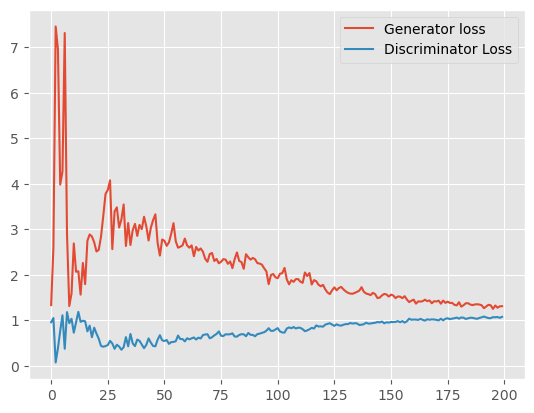

In [33]:
plt.figure()
losses_g = [fl.item() for fl in losses_g ]
plt.plot(losses_g, label='Generator loss')
losses_d = [f2.item() for f2 in losses_d ]
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()

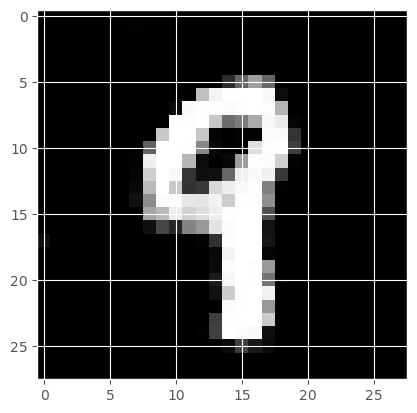

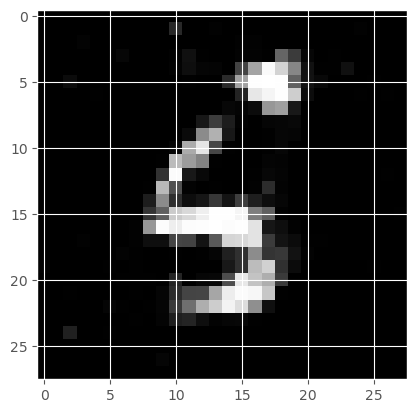

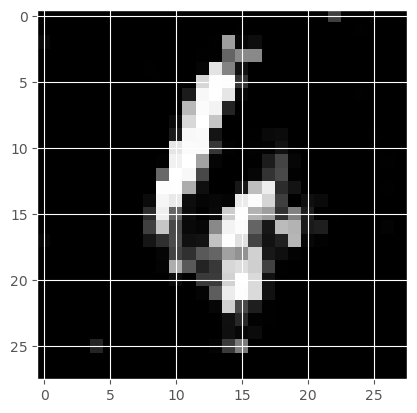

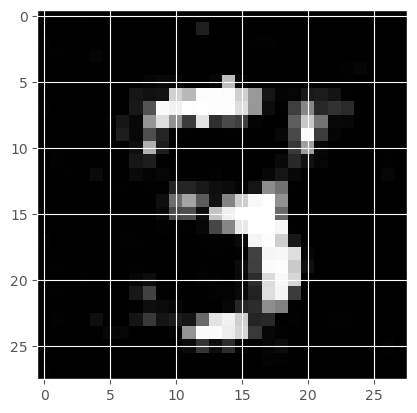

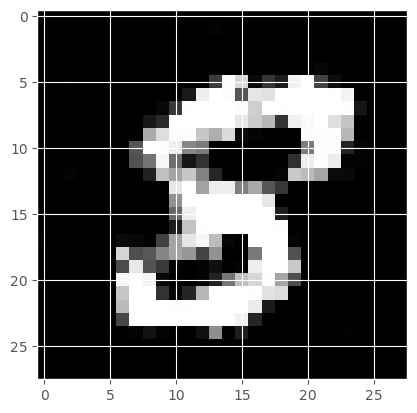

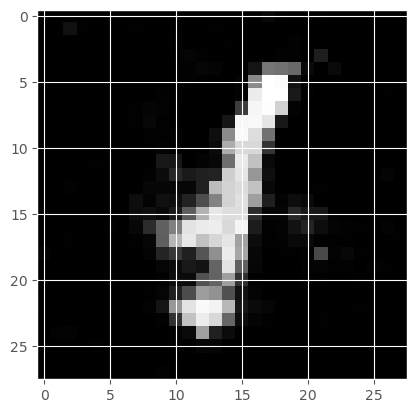

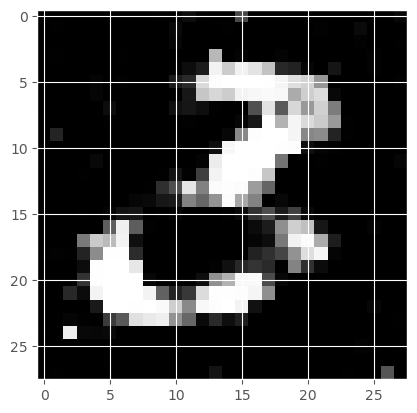

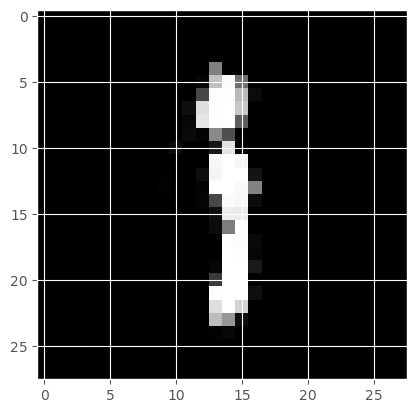

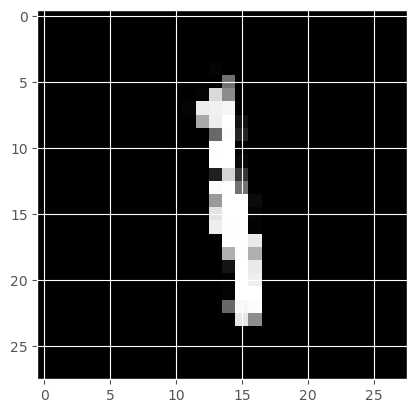

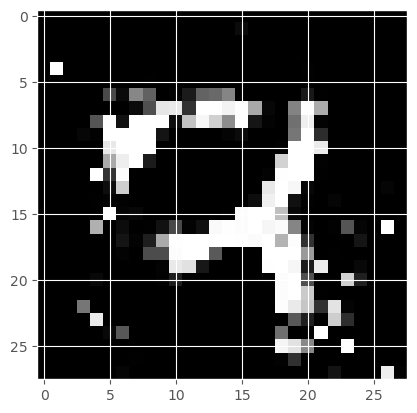

In [34]:
fake_images = generator(torch.randn(b_size, nz).to(device))
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28, 28))
    plt.imshow(fake_images_img, cmap = 'gray')    
    plt.show()